<a href="https://colab.research.google.com/github/eTcilopp/geek_brains/blob/main/43_data_science_libs/hw10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 10

1. Первичный анализ данных:
— Импортировать данные из файла ds_salaries.csv.
— Очистить данные от дубликатов и пропущенных значений.
— Исследовать типы данных, описательную статистику и корреляции между признаками.
— Визуализировать данные с помощью Matplotlib и Seaborn.

2. Построение модели линейной регрессии:
— Разделить данные на обучающую и тестовую выборки.
— Построить модель линейной регрессии для прогнозирования заработной платы.
— Оценить качество модели с помощью метрик MAE, MSE и R-квадрат.
— Проанализировать значимость признаков и мультиколлинеарность.

3. Построение модели дерева решений:
— Построить модель дерева решений для прогнозирования заработной платы.
— Оценить качество модели с помощью метрик RMSE и R-квадрат.
— Подберите гиперпараметры для модели дерево решений
— Визуализировать дерево решений.

4. Построение ансамблевой модели:
— Построить ансамблевую модель, используя Random Forest и Boosting.
— Сравнить качество ансамблевой модели с отдельными моделями.
— Оценить важность признаков в ансамблевой модели.

5. Понижение размерности:
— Применить Principal Component Analysis (PCA) для снижения размерности данных.
— Построить модель линейной регрессии с использованием данных, полученных после PCA.
— Сравнить качество модели с использованием исходных данных.

7. Кластеризация:
— Применить метод K-Means для кластеризации данных по заработной плате.
— Определить оптимальное количество кластеров.
— Проанализировать характеристики полученных кластеров.
— Визуализировать результаты кластеризации и проанализировать характеристики в каждом кластере.
— Проанализируйте полученные данные и сделайте выводы о том, какой алгоритм кластеризации сможет выделить кластеры лучше, чем K-Means.

In [60]:
!pip install bayesian-optimization -q

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from bayes_opt import BayesianOptimization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Загрузка данных и первичный анализ

In [2]:
data = pd.read_csv('https://gbcdn.mrgcdn.ru/uploads/asset/6088906/attachment/07db7379b46e702ce9c4cc164bae62b9.csv')

In [3]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [5]:
data.isna().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


Разобъем датасет на три по типу фичей

In [6]:
data_numeric = data.select_dtypes(include='number')
data_categorical = data.select_dtypes(include='object')

In [7]:
data_numeric.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


Посмотрим на корреляцию между признаками

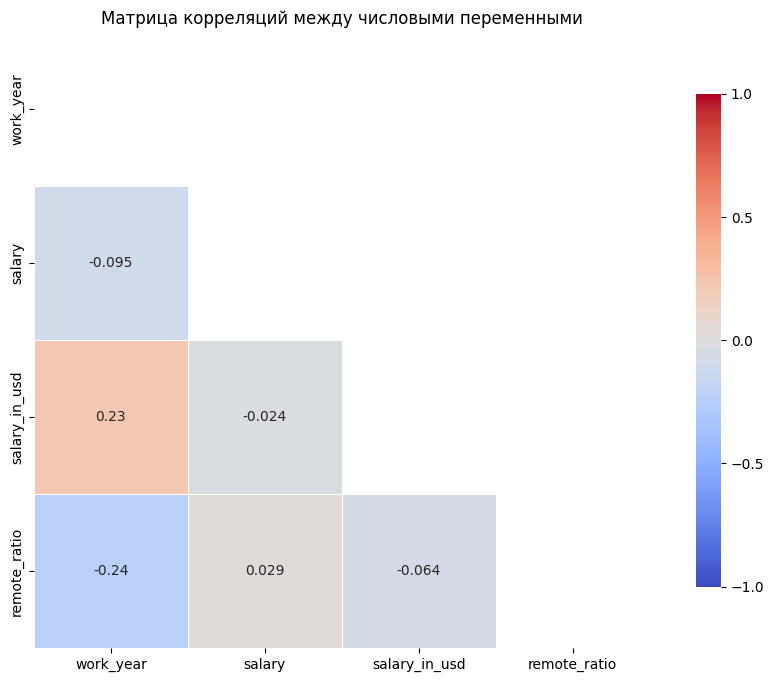

In [8]:
correlation_matrix = data_numeric.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot_kws={"size": 10},
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
plt.title('Матрица корреляций между числовыми переменными')
plt.show()

Никаких особых инсайдов: наблюдается незначительная корреляция между зарплатой и выслугой лет, что объяснимо.

Посмотрим на имеющиеся выбросы в данных

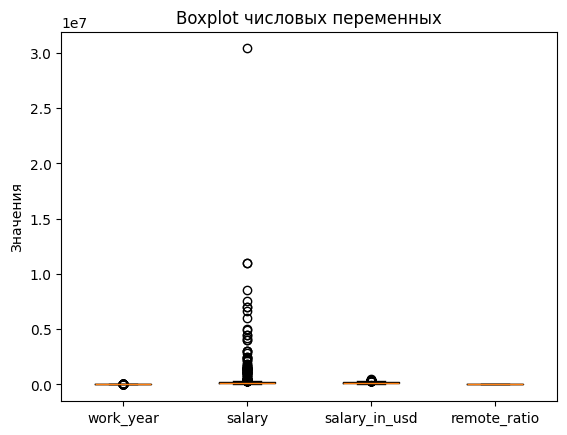

In [9]:
plt.boxplot(data_numeric, labels=data_numeric.columns)
plt.title('Boxplot числовых переменных')
plt.ylabel('Значения')
plt.show()

Наблюдаем значительные выбросы в категории "Salary", что объясняется использованием различных валют.
<br>
Очевидно, для модели стедует использовать зарплаты, приведенные к одной валюте (USD)

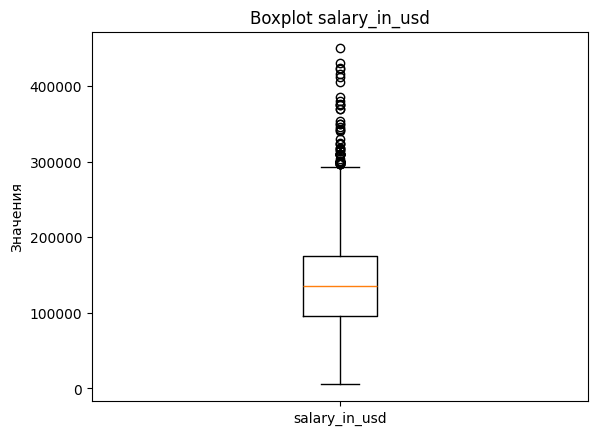

In [10]:
plt.boxplot(data_numeric['salary_in_usd'])
plt.title('Boxplot salary_in_usd')
plt.ylabel('Значения')
plt.xticks([1], ['salary_in_usd'])
plt.show()

В самой salary_in_usd также наблюдаются выбросы - потребуется нормализация.

In [11]:
scaler = StandardScaler()

scaled_numerical = scaler.fit_transform(data_numeric)
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=data_numeric.columns)

In [12]:
scaled_numerical_df.head(3)

,work_year,salary,salary_in_usd,remote_ratio
0,0.905994,-0.164827,-0.820391,1.105918
1,0.905994,-0.239277,-1.706187,1.105918
2,0.905994,-0.245978,-1.777563,1.105918


Закодируем категориальные данные

In [13]:
for column in data_categorical.columns:
    print(f'{column}: {len(data_categorical[column].unique())}')

experience_level: 4
employment_type: 4
job_title: 93
salary_currency: 20
employee_residence: 78
company_location: 72
company_size: 3


Для категорий с небольшим числом значений используем one-hot encoding

In [14]:
one_hot_columns = [column for column in data_categorical.columns if len(data_categorical[column].unique()) < 10]

In [15]:
one_hot_columns

['experience_level', 'employment_type', 'company_size']

In [16]:
data_categorical_encoded = pd.get_dummies(data_categorical, columns=one_hot_columns,  drop_first=True)

In [17]:
data_categorical_encoded.head(3)

,job_title,salary_currency,employee_residence,company_location,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,company_size_M,company_size_S
0,Principal Data Scientist,EUR,ES,ES,False,False,True,False,True,False,False,False
1,ML Engineer,USD,US,US,False,True,False,False,False,False,False,True
2,ML Engineer,USD,US,US,False,True,False,False,False,False,False,True


Для категорий с большим числом значений используем словари

In [18]:
dict_columns = [column for column in data_categorical.columns if column not in one_hot_columns]

In [19]:
dict_columns

['job_title', 'salary_currency', 'employee_residence', 'company_location']

Сначала получим словари

In [20]:
dict_of_dicts = {}
for column in dict_columns:
    unique_values = data_categorical[column].unique()
    value_to_index = {value: index for index, value in enumerate(unique_values)}
    dict_of_dicts[column] = value_to_index

Потом конвертируем категориальные данные в закодированные числовые

In [21]:
for column in dict_columns:
    data_categorical_encoded[column] = data_categorical[column].map(dict_of_dicts[column])

In [22]:
data_categorical_encoded.head()

,job_title,salary_currency,employee_residence,company_location,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,company_size_M,company_size_S
0,0,0,0,0,False,False,True,False,True,False,False,False
1,1,1,1,1,False,True,False,False,False,False,False,True
2,1,1,1,1,False,True,False,False,False,False,False,True
3,2,1,2,2,False,False,True,False,True,False,True,False
4,2,1,2,2,False,False,True,False,True,False,True,False


Получим итоговый датасет для анализа

In [27]:
data_combined = pd.concat([scaled_numerical_df, data_categorical_encoded], axis=1).drop('salary', axis=1)

Построим модель линейной регрессии

In [28]:
X = data_combined.drop('salary_in_usd', axis=1)
y = data_combined['salary_in_usd']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred = regression_model.predict(X_test)

In [34]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(
    f'RMSE: {rmse}\n'
    f'R2: {r2}'
)

RMSE: 0.887139515564191
R2: 0.20756832946699433


## Выводы
Ошибка составляет в среднем 0.887 в тех же единицах, что и целевая переменная.
<br>
Это не идеальный, но и не катастрофический результат
<br>
Модель объясняет только 20.8% вариации целевой переменной, что говорит о низкой предсказательной способности.
<br>
Нужно улучшать модель

Построим модель дерева решений

In [36]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [37]:
print(
    f'RMSE: {rmse}\n'
    f'R2: {r2}'
)

RMSE: 0.8535123806965086
R2: 0.26650420897764315


Результаты примерно такие же. Попробуем подобрать гиперпараметры

In [39]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"Лучшие гиперпараметры для модели из коробки (Grid Search): {grid_search.best_params_}")
print(f"Лучшая оценка для модели из коробки (Grid Search): {grid_search.best_score_:.2f}")

Лучшие гиперпараметры для модели из коробки (Grid Search): {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}
Лучшая оценка для модели из коробки (Grid Search): 0.38


Используем найденные параметры для построения модели

In [40]:
tree_model_2 = DecisionTreeRegressor(**grid_search.best_params_)
tree_model_2.fit(X_train, y_train)

y_pred = tree_model_2.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(
    f'RMSE: {rmse}\n'
    f'R2: {r2}'
)

RMSE: 0.7859833774398138
R2: 0.37797949942091236


RMSE ухудшилось, показатель R2 заметно подскочил.

Визуализируем дерево

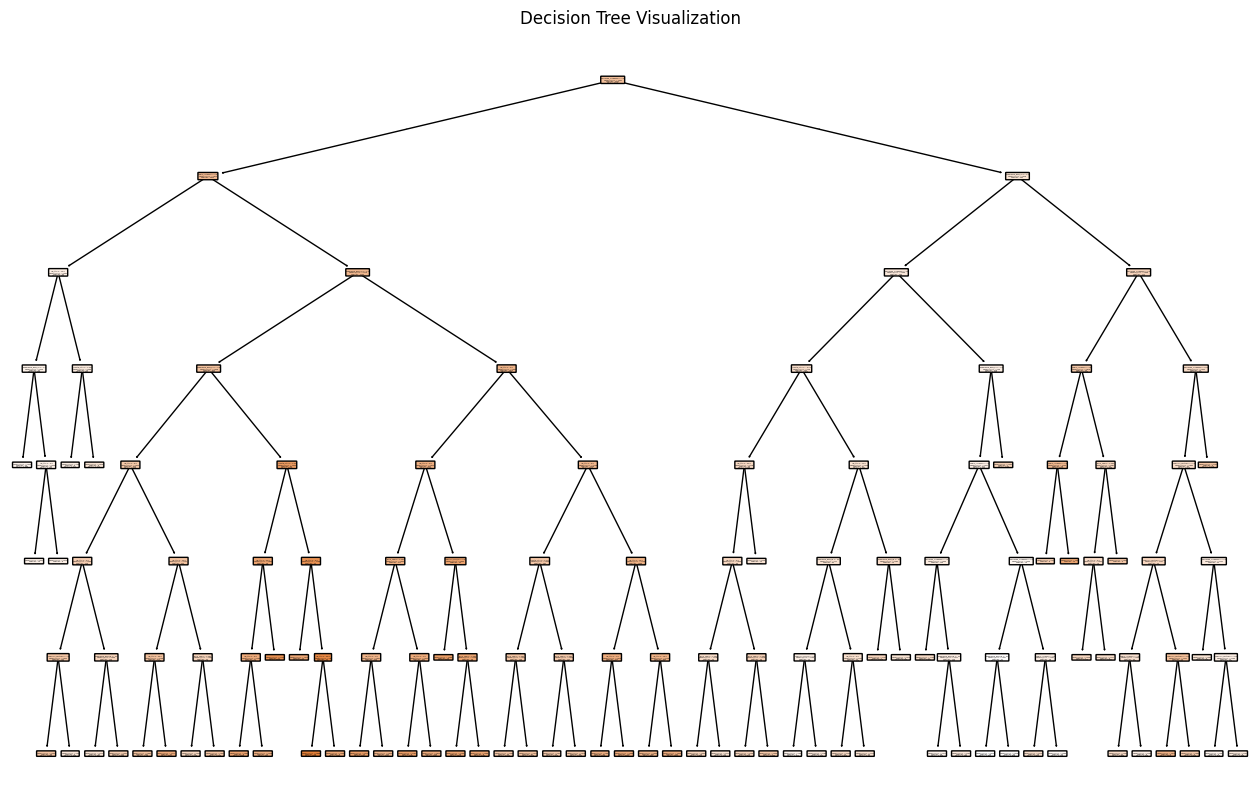

In [45]:
plt.figure(figsize=(16, 10))
plot_tree(tree_model_2, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

Получилось очень красиво

Построим ансамблевую модель

In [51]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

train_mse_rf = mean_squared_error(y_train, model_rf.predict(X_train))
train_rmse_rf = np.sqrt(train_mse_rf)

test_mse_rf = mean_squared_error(y_test, y_pred)
test_rmse_rf = np.sqrt(test_mse_rf)

In [53]:
print(
    f'RMSE на обучающей выборке: {train_rmse_rf:.2f}\n'
    f'RMSE на тестовой выборке: {test_rmse_rf:.2f}'
)

RMSE на обучающей выборке: 0.64
RMSE на тестовой выборке: 0.77


Получили довольно плохой результат: чуть лучше, чем у отдельных моделей
<br>
Оценим важности признаков

In [56]:
importances = model_rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

Визуализируем важности

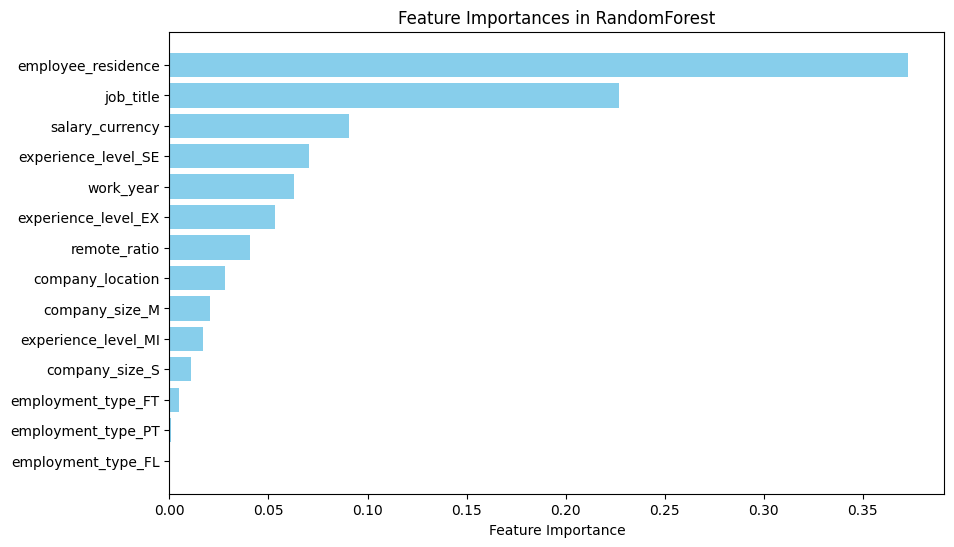

In [57]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in RandomForest')
plt.gca().invert_yaxis()
plt.show()

Важный вывод: на зарплату главным образом влияет место жительства, локация. Что, впрочем, понятно.

Построим Boosting модель. Для разнообразия попробуем оптимизировать ее

In [58]:
param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (1, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'max_features': (0.1, 1.0)
}

In [63]:
def gradient_boosting_regression_cross_validation(**kwargs):
    n_estimators = int(kwargs.get('n_estimators'))
    max_depth = None if int(kwargs.get('max_depth')) == 0 else int(kwargs.get('max_depth'))
    min_samples_split = int(kwargs.get('min_samples_split'))
    min_samples_leaf = int(kwargs.get('min_samples_leaf'))
    max_features = float(kwargs.get('max_features'))

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )


    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='neg_mean_squared_error',
        cv=5
    )

    return scores.mean()

In [64]:
optimizer = BayesianOptimization(
    f=gradient_boosting_regression_cross_validation,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

In [65]:
optimizer.maximize(init_points=10, n_iter=30)
best_params_gb = optimizer.max['params']

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.6232   | 11.86     | 0.9556    | 3.196     | 6.789     | 131.2     |
| 2         | -0.5865   | 5.524     | 0.1523    | 3.599     | 6.809     | 241.6     |
| 3         | -0.6282   | 1.597     | 0.9729    | 3.497     | 3.699     | 136.4     |
| 4         | -0.5976   | 6.319     | 0.3738    | 2.574     | 5.456     | 158.2     |
| 5         | -0.6497   | 18.74     | 0.2255    | 1.876     | 4.931     | 191.2     |
| 6         | -0.6364   | 23.77     | 0.2797    | 2.543     | 6.739     | 109.3     |
| 7         | -0.6468   | 18.62     | 0.2535    | 1.195     | 9.591     | 293.1     |
| 8         | -0.6472   | 24.44     | 0.3742    | 1.293     | 7.474     | 188.0     |
| 9         | -0.5791   | 4.539     | 0.5457    | 1.103     | 9.275     | 151.8     |
| 10        | -0.6439   | 20.21     | 0.3805    | 2.56

Извлечем оптимальные параметры

In [66]:
best_params_gb['n_estimators'] = int(best_params_gb['n_estimators'])
best_params_gb['max_depth'] = int(best_params_gb['max_depth'])
best_params_gb['min_samples_split'] = int(best_params_gb['min_samples_split'])
best_params_gb['min_samples_leaf'] = int(best_params_gb['min_samples_leaf'])
best_params_gb['max_features'] = float(best_params_gb['max_features'])

Построим модель градиентного бустинга с оптимизированными параметрами

In [67]:
model_gb = RandomForestRegressor(
    **best_params_gb,
    random_state=42,
    n_jobs=-1
)
model_gb.fit(X_train, y_train)

train_preds_gb = model_gb.predict(X_train)
train_mse_gb = mean_squared_error(y_train, train_preds_gb)
train_rmse_gb = np.sqrt(train_mse_gb)

test_preds_gb = model_gb.predict(X_test)
test_mse_gb = mean_squared_error(y_test, test_preds_gb)
test_rmse_gb = np.sqrt(test_mse_gb)

In [68]:
print(f'RMSE на обучающей выборке: {train_rmse_gb:.2f}')
print(f'RMSE на тестовой выборке: {test_rmse_gb:.2f}')

RMSE на обучающей выборке: 0.82
RMSE на тестовой выборке: 0.83


Показатели почему-то ухудшились.

Попробуем понизить размерность

In [69]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [71]:
print(f"Размерность после PCA: {X_pca.shape}")
print(f"Доля объяснённой дисперсии: {pca.explained_variance_ratio_}")
print(f"Суммарная доля объяснённой дисперсии: {pca.explained_variance_ratio_.sum()}")

Размерность после PCA: (3755, 3)
Доля объяснённой дисперсии: [0.22972714 0.1235517  0.10663732]
Суммарная доля объяснённой дисперсии: 0.459916162484979


Построим модель линейной регрессии на данных пониженной размерности

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)


model_pca = LinearRegression()
model_pca.fit(X_train, y_train)

y_pred_pca = model_pca.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_pca, squared=False)
r2 = r2_score(y_test, y_pred_pca)
print(
    f'RMSE: {rmse}\n'
    f'R2: {r2}'
)

RMSE: 0.9157969293813177
R2: 0.15914212448505805


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Средняя ошибка модели составляет 0.916 в тех же единицах, что и целевая переменная. Это указывает на значительное отклонение предсказанных значений от реальных.<br>
Модель объясняет всего 15.9% вариации целевой переменной, что крайне низкий показатель.<br>
Это говорит о том, что модель плохо отражает зависимость между признаками и целевой переменной.
<br>
Мы потеряли много информации при понижении размерности

Применим метод К средних для кластеризации данных

In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_combined)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

Посмотрим на получившиеся кластеры

In [81]:
clusters = kmeans.labels_

In [82]:
data_combined['Cluster'] = kmeans.labels_

In [83]:
grouped = data_combined.groupby('Cluster').mean()
print(grouped)

         work_year  salary_in_usd  remote_ratio  job_title  salary_currency  \
Cluster                                                                       
0        -0.492578      -0.654503      0.126877  16.215993         1.918199   
1        -1.391281      -1.554972      0.621600  18.352941         3.000000   
2         0.211161       0.278692     -0.056079  10.093962         1.023774   

         employee_residence  company_location  experience_level_EX  \
Cluster                                                              
0                  8.689338          7.812500             0.022059   
1                 27.882353         14.941176             0.000000   
2                  1.253208          1.249811             0.033962   

         experience_level_MI  experience_level_SE  employment_type_FL  \
Cluster                                                                 
0                   0.735294             0.079963            0.009191   
1                   0.176471      

Визуализируем кластеры

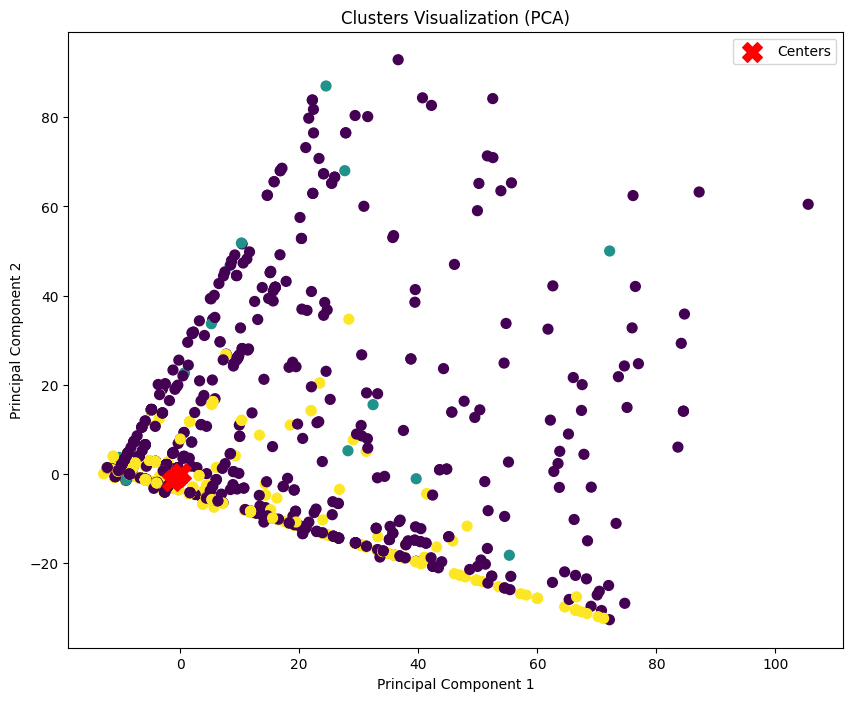

In [85]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_combined)

# 2. Визуализация кластеров
plt.figure(figsize=(10, 8))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centers')
plt.title("Clusters Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Выводы
Результаты кластеризации не дают явных "инсайдов". Не смотря на то, что просматриваются некоторые паттерны, явного разделения на кластеры не произошло:
центры кластеров сливаются
<br>
Возможно, кластеризация на основе ПЛОТНОСИ дала бы лучший результат